In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
from IPython.display import Image
import pymc3 as pm
import arviz as az
import scipy
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm
from sklearn import preprocessing

%matplotlib inline
plt.style.use('bmh')
colors = ['#D55E00', '#009E73', '#0072B2', '#348ABD', '#A60628', 
          '#7A68A6', '#467821', '#CC79A7', '#56B4E9', '#F0E442']

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
tweets = pd.read_csv('twcs.csv')
tweets.shape

(1048575, 7)

In [3]:
tweets.head(3)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0


In [4]:
first_inbound = tweets[pd.isnull(tweets.in_response_to_tweet_id) & tweets.inbound]
df = pd.merge(first_inbound, tweets, left_on='tweet_id', right_on='in_response_to_tweet_id')
df = df[df.inbound_y ^ True]
df = df[["author_id_x","created_at_x","text_x","author_id_y","created_at_y","text_y"]]

df['created_at_x'] = pd.to_datetime(df['created_at_x'], format='%a %b %d %H:%M:%S +0000 %Y')
df['created_at_y'] = pd.to_datetime(df['created_at_y'], format='%a %b %d %H:%M:%S +0000 %Y')

#Calculating time between outbound response and inbound message
df['response_time'] = df['created_at_y'] - df['created_at_x']
# Convert to minutes
df['response_time'] = df['response_time'].astype('timedelta64[s]') / 60

Only select airline companies.

In [5]:
df = df[(df.author_id_y == 'Delta') | (df.author_id_y == 'AmericanAir') | (df.author_id_y == 'SouthwestAir') | (df.author_id_y == 'British_Airways') | (df.author_id_y == 'AmericanAir') | (df.author_id_y == 'AirAsiaSupport') | (df.author_id_y == 'VirginAtlantic') | (df.author_id_y == 'AlaskaAir') | (df.author_id_y == 'British_Airways') | (df.author_id_y == 'VirginAmerica') | (df.author_id_y == 'JetBlue')]

In [6]:
df.response_time.describe()

count    41344.000000
mean       129.519000
std        686.519969
min          0.083333
25%          4.283333
50%         14.400000
75%         60.037500
max      44974.900000
Name: response_time, dtype: float64

Anything longer than 60 minutes will be filtered out. We are working on tickets that get response in 60 minutes.

In [7]:
df = df.loc[df['response_time'] <= 60]

In [7]:
df.shape

(31006, 7)

In [8]:
# Time attributes
df['created_at_y_dayofweek'] = df['created_at_y'].apply(lambda x: x.dayofweek)
df['created_at_y_day_of_week'] = df['created_at_y'].dt.weekday_name
df['created_at_y_day'] = df['created_at_y'].dt.day
df['created_at_y_is_weekend'] = df['created_at_y_dayofweek'].isin([5,6]).apply(lambda x: 1 if x == True else 0)
df['word_count'] = df.text_y.apply(lambda x: len(str(x).split()))

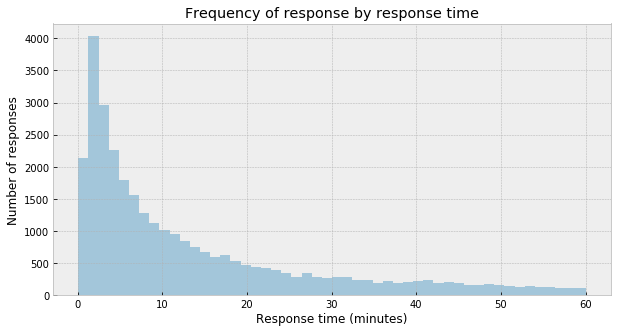

In [10]:
plt.figure(figsize=(10,5))
sns.distplot(df['response_time'], kde=False)
plt.title('Frequency of response by response time')
plt.xlabel('Response time (minutes)')
plt.ylabel('Number of responses');

A Gaussian distribution is not a proper description of the data.

## Student's t-distribution

One very useful option when dealing with outliers and Gaussian distributions is to replace the Gaussian likelihood with a Student's t-distribution. This distribution has three parameters: the mean $(\mu)$, the scale $(\sigma)$ (analogous to the standard deviation), and the degrees of freedom $(\nu)$.

For a value of ν = 1, we get a distribution with very heavy tails, it is more probable to find values away from the mean compared to a Gaussian.

The exponential here is parameterized with the inverse of the mea.

In [9]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', lower=0, upper=60)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/1)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=df['response_time'])
    trace_t = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, σ, μ]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:31<00:00, 251.15draws/s]


## MCMC diagnostics

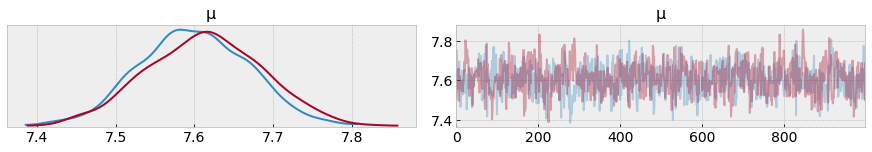

In [10]:
az.plot_trace(trace_t[:1000], var_names = ['μ']);

In [18]:
df['response_time'].mean()

13.765086327377496

100%|██████████| 1000/1000 [00:05<00:00, 168.66it/s]


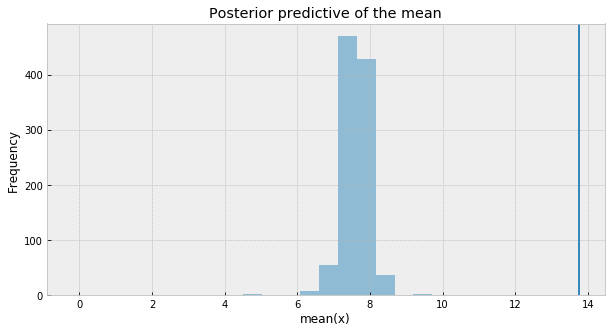

In [13]:
ppc = pm.sample_posterior_predictive(trace_t, samples=1000, model=model_t)
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([n.mean() for n in ppc['y']], bins=19, alpha=0.5)
ax.axvline(df['response_time'].mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

This is vary bad. The inferred mean's uncertainty is 7.4 to 7.8, and that is so far away from the actural sample mean. Student's t-distribution is not a proper choice.

## Poisson Distribution

Poisson distribution is generally used to describe the probability of a given number of events occurring on a fixed time/space interval. Thus, the Poisson distribution assumes that the events occur independently of each other and at a fixed interval of time and/or space. This discrete distribution is parametrized using only one value mu, which corresponds to the mean and also the variance of the distribution.

In [14]:
df.groupby(['author_id_y', 'created_at_y_is_weekend'])['response_time'].mean()

author_id_y      created_at_y_is_weekend
AirAsiaSupport   0                          21.516414
                 1                          20.337187
AlaskaAir        0                           6.250340
                 1                           4.157718
AmericanAir      0                          15.792283
                 1                          16.278190
British_Airways  0                          24.279305
                 1                          23.021521
Delta            0                          15.488946
                 1                          17.564840
JetBlue          0                           5.448716
                 1                           4.938405
SouthwestAir     0                          10.812559
                 1                           9.760009
VirginAmerica    0                           6.543657
                 1                           4.380241
VirginAtlantic   0                          19.360185
                 1                       

In [15]:
df.groupby('created_at_y_day_of_week')['response_time'].mean()

created_at_y_day_of_week
Friday       13.754650
Monday       15.371081
Saturday     13.355185
Sunday       14.983126
Thursday     12.935208
Tuesday      15.381594
Wednesday    12.188707
Name: response_time, dtype: float64

In [16]:
df.groupby('created_at_y_is_weekend')['response_time'].mean()

created_at_y_is_weekend
0    13.636924
1    14.075243
Name: response_time, dtype: float64

In [17]:
with pm.Model() as model_p:
    μ = pm.Uniform('μ', lower=0, upper=60)
    ## Define Poisson likelihood
    y = pm.Poisson('y', mu=μ, observed=df['response_time'].values)
    trace_p = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:06<00:00, 1263.22draws/s]


## MCMC diagnostics

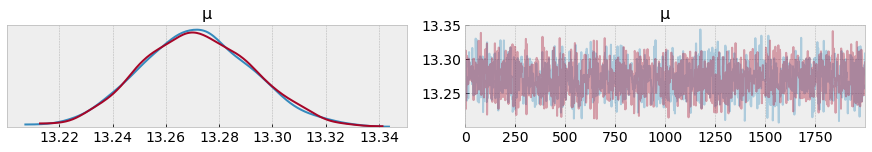

In [18]:
az.plot_trace(trace_p);

The above code has just gathered 5000 credible samples of mu by traversing over the areas of high likelihood of the posterior distribution of mu. The plot (left) shows the distribution of values collected for mu. What we get is a measure of uncertainty and credible values of mu between 13.20 and 13.34. It sounds way better already.

## Autocorrelations

The autocorrelation drops with increasing x-axis in the plot, which is a good sign. Because this indicates a low degree of correlation between our samples.

Ideally, we should see no autocorrelation. In practice, we want samples that quickly drop to low values of autocorrelation. Our samples from the Poisson model has dropped to almost no autocorrelation.

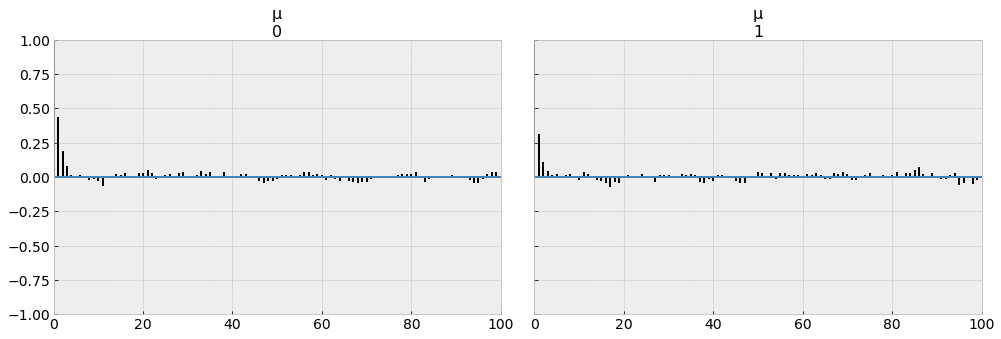

In [19]:
_ = pm.autocorrplot(trace_p, var_names=['μ'])

There are multiple ways to do posterior predictive checks.

## Posterior Predictive Checks

100%|██████████| 100/100 [00:00<00:00, 235.57it/s]


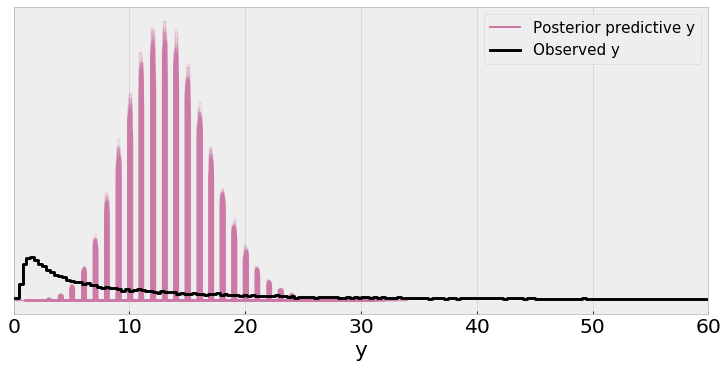

In [20]:
y_ppc_p = pm.sample_posterior_predictive(
    trace_p, 100, model_p, random_seed=123)
y_pred_p = az.from_pymc3(trace=trace_p, posterior_predictive=y_ppc_p)
az.plot_ppc(y_pred_p, figsize=(10, 5), mean=False)
plt.xlim(0, 60);

### Interpretation: 

* The single (black) line is a kernel density estimate (KDE) of the data and the many purple lines are KDEs computed from each one of the 100 posterior predictive samples. The purple lines reflect the uncertainty we have about the inferred distribution of the predicted data.

* From the above plot, I  can't  consider the scale of a Poisson distribution as a reasonable practical proxy for the standard deviation of the data after removing outliers.

## Posterior Predictive Checks

The following process will randomly draw 1000 samples of parameters from the trace. Then, for each sample, it will draw 31006 random numbers from a Poisson distribution specified by the values of $(\mu)$ in that sample.

100%|██████████| 1000/1000 [00:04<00:00, 236.68it/s]


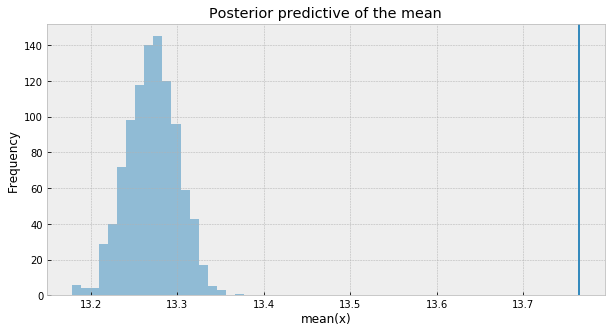

In [21]:
ppc = pm.sample_posterior_predictive(trace_p, samples=1000, model=model_p)
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([n.mean() for n in ppc['y']], bins=19, alpha=0.5)
ax.axvline(df['response_time'].mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

The inferred means to the actual sample mean are much closer than what we got from Student T distribution. But still, there is a small gap.

The problem with using a Poisson distribution is that mean and variance are linked (in fact they are described by the same parameter). So one way to solve this problem is to model the data as a (continuous) mixture of Poisson distributions with rates coming from a gamma distribution, which gives us the rationale to use the negative-binomial distribution.

## Negative binomial distribution

Negative binomial regression is used to model count data for which the variance is higher than the mean. Negative Binomial distribution has very similar characteristics to the Poisson distribution except that it has two parameters ($\mu$ and $\alpha$) which enables it to vary its variance independently of its mean. Recall that the Poisson distribution has one parameter ($\mu$) that represents both its mean and its variance.

The negative binomial distribution describes a Poisson random variable whose rate parameter is gamma distributed.

In [22]:
df.groupby(['author_id_y', 'created_at_y_is_weekend'])['response_time'].agg(['mean', 'var'])

mean         var
author_id_y     created_at_y_is_weekend                       
AirAsiaSupport  0                        21.516414  199.979114
                1                        20.337187  237.087055
AlaskaAir       0                         6.250340   61.210038
                1                         4.157718   24.122234
AmericanAir     0                        15.792283  184.064094
                1                        16.278190  212.116030
British_Airways 0                        24.279305  305.224291
                1                        23.021521  220.016556
Delta           0                        15.488946  258.286447
                1                        17.564840  301.038111
JetBlue         0                         5.448716   35.123633
                1                         4.938405   30.991573
SouthwestAir    0                        10.812559  137.190738
                1                         9.760009   92.872131
VirginAmerica   0                         6.543657   67.944916
                1                         4.380241   33.984369
VirginAtlantic  0                        19.360185  294.285267
                1                        21.798914  242.880161

In [23]:
with pm.Model() as model_n:
    
    μ = pm.Uniform('μ', lower=0, upper=60)
    α = pm.Uniform('α', lower=0, upper=100)
    
    y_pred = pm.NegativeBinomial('y_pred', mu=μ, alpha=α)
    y_est = pm.NegativeBinomial('y_est', mu=μ, alpha=α, observed=df['response_time'].values)
    
    trace_n = pm.sample(2000, tune=2000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [α, μ]
>Metropolis: [y_pred]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:54<00:00, 146.69draws/s]
The number of effective samples is smaller than 10% for some parameters.


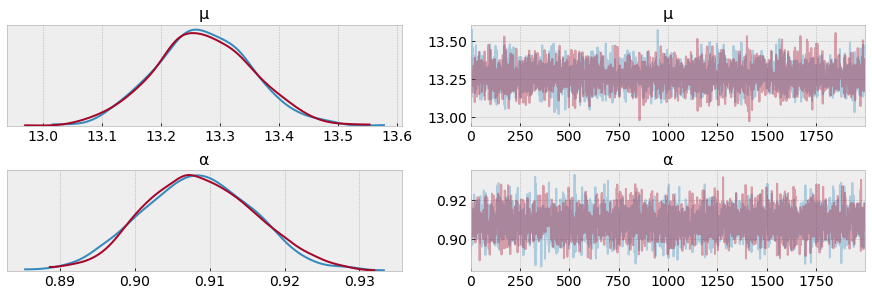

In [37]:
az.plot_trace(trace_n, var_names=['μ', 'α']);

## Posterior Predictive Check

100%|██████████| 100/100 [00:00<00:00, 124.45it/s]


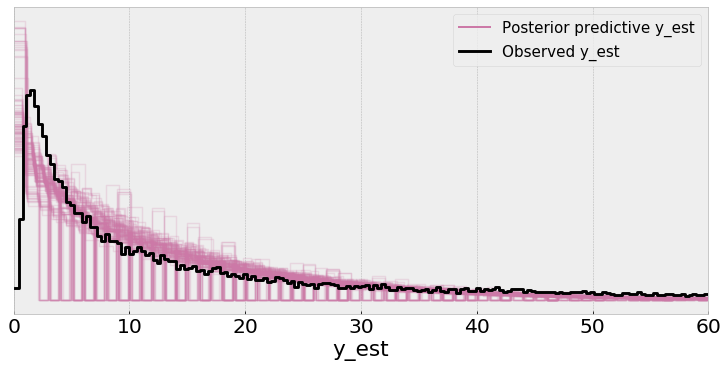

In [33]:
y_ppc_n = pm.sample_posterior_predictive(
    trace_n, 100, model_n, random_seed=123)
y_pred_n = az.from_pymc3(trace=trace_n, posterior_predictive=y_ppc_n)
az.plot_ppc(y_pred_n, figsize=(10, 5), mean=False)
plt.xlim(0, 60);

Way better!

100%|██████████| 1000/1000 [00:07<00:00, 125.37it/s]


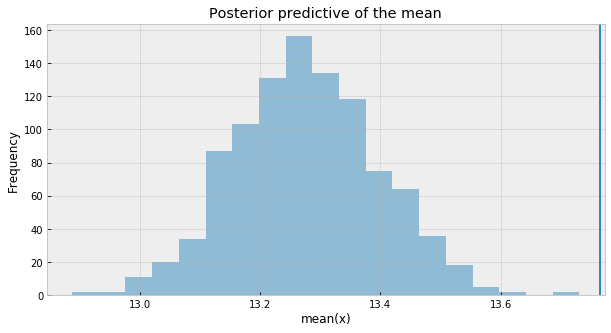

In [35]:
ppc = pm.sample_posterior_predictive(trace_n, samples=1000, model=model_n)
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([n.mean() for n in ppc['y_est']], bins=19, alpha=0.5)
ax.axvline(df['response_time'].mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

This is what we get:

* Student t-distribution: 7.4 to 7.8

* Poisson distribution 13.2 to 13.36

* Negative Binomial distribution 13.0 to 13.6

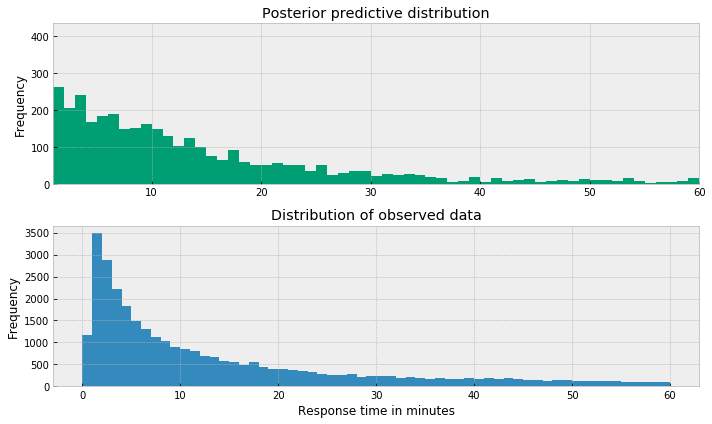

In [36]:
x_lim = 60

y_pred = trace_n.get_values('y_pred')
mu_mean = trace_n.get_values('μ').mean()

fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(df['response_time'].values, range=[0, x_lim], bins=x_lim)
_ = plt.xlabel('Response time in minutes')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout();

The posterior predictive distribution does resemble the distribution of the observed data, suggests that the Negative Binomial model is a more appropriate fit for the underlying data.

## Bayesian Methods for Hierarchical Modeling

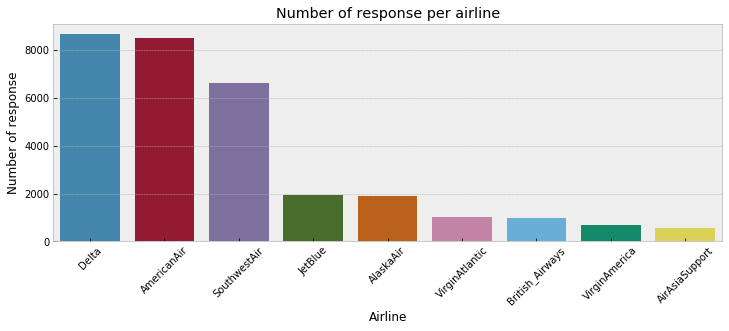

In [24]:
plt.figure(figsize=(12,4))
sns.countplot(x="author_id_y", data=df, order = df['author_id_y'].value_counts().index)
plt.xlabel('Airline')
plt.ylabel('Number of response')
plt.title('Number of response per airline')
plt.xticks(rotation=45);

In [38]:
indiv_traces = {}

# Convert categorical variables to integer
le = preprocessing.LabelEncoder()
airlines_idx = le.fit_transform(df['author_id_y'])
airlines = le.classes_
n_airlines = len(airlines)

for p in airlines:
    with pm.Model() as model_h:
        α = pm.Uniform('α', lower=0, upper=100)
        μ = pm.Uniform('μ', lower=0, upper=60)
        
        data = df[df['author_id_y']==p]['response_time'].values
        y_est = pm.NegativeBinomial('y_est', mu=μ, alpha=α, observed=data)

        y_pred = pm.NegativeBinomial('y_pred', mu=μ, alpha=α)
        
        trace_h = pm.sample(2000, tune=2000)
        
        indiv_traces[p] = trace_h

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [μ, α]
>Metropolis: [y_pred]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1361.19draws/s]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [μ, α]
>Metropolis: [y_pred]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:08<00:00, 955.76draws/s] 
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [μ, α]
>Metropolis: [y_pred]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:19<00:00, 411.78draws/s]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [μ, α]
>Metropolis: [y_pred]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:06<00:00, 1180.92draws/s]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 2 

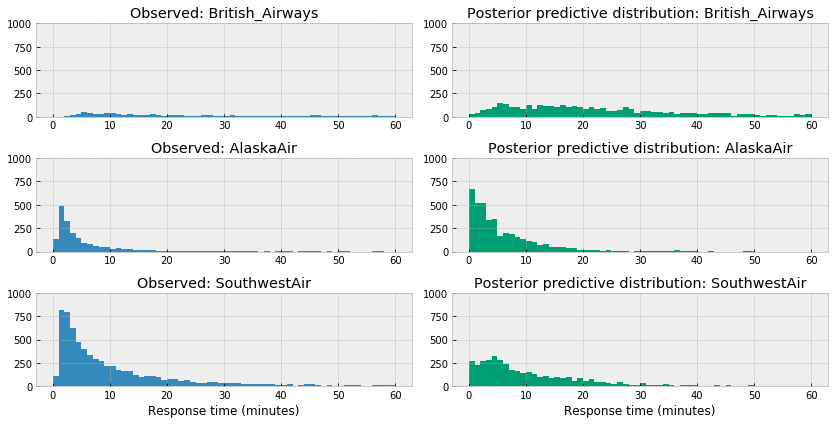

In [42]:
fig, axs = plt.subplots(3,2, figsize=(12, 6))
axs = axs.ravel()
y_left_max = 1000
y_right_max = 1000
x_lim = 60
ix = [3,1,6]

for i, j, p in zip([0,1,2], [0,2,4], airlines[ix]):
    axs[j].set_title('Observed: %s' % p)
    axs[j].hist(df[df['author_id_y']==p]['response_time'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
    axs[j].set_ylim([0, y_left_max])

for i, j, p in zip([0,1,2], [1,3,5], airlines[ix]):
    axs[j].set_title('Posterior predictive distribution: %s' % p)
    axs[j].hist(indiv_traces[p].get_values('y_pred'), range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])
    axs[j].set_ylim([0, y_right_max])

axs[4].set_xlabel('Response time (minutes)')
axs[5].set_xlabel('Response time (minutes)')

plt.tight_layout();

Amongst the above three airlines, some of the posterior predictive distribution vary considerably. For example, the distribution of British Airways towards right, This could accurately reflect the characteristics of its response time, means it takes longer for British Airways customer service twitter to respond than those of AlaskaAir or SouthwestAir. Or it could be incomplete due to small sample size, as we have way more data from Southwest than from British airways.

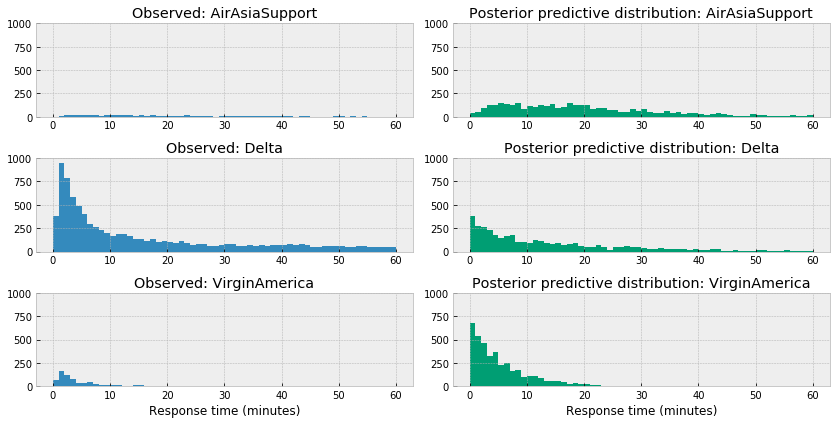

In [43]:
fig, axs = plt.subplots(3,2, figsize=(12, 6))
axs = axs.ravel()
y_left_max = 1000
y_right_max = 1000
x_lim = 60
ix = [0,4,7]

for i, j, p in zip([0,1,2], [0,2,4], airlines[ix]):
    axs[j].set_title('Observed: %s' % p)
    axs[j].hist(df[df['author_id_y']==p]['response_time'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
    axs[j].set_ylim([0, y_left_max])

for i, j, p in zip([0,1,2], [1,3,5], airlines[ix]):
    axs[j].set_title('Posterior predictive distribution: %s' % p)
    axs[j].hist(indiv_traces[p].get_values('y_pred'), range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])
    axs[j].set_ylim([0, y_right_max])

axs[4].set_xlabel('Response time (minutes)')
axs[5].set_xlabel('Response time (minutes)')

plt.tight_layout();

Same thing here. Amongst the above three airlines,the distribution of AirAsia towards right, This could accurately reflect the characteristics of its response time, means in general, it takes longer for AirAsia customer service twitter to respond than those of Delta or VirginAmerica. Or it could be incomplete due to small sample size, as we have way more data from Delta than from AirAsia.

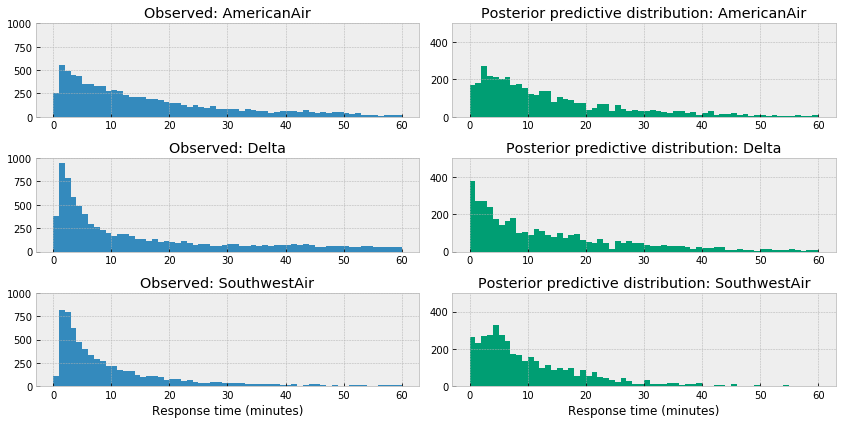

In [44]:
fig, axs = plt.subplots(3,2, figsize=(12, 6))
axs = axs.ravel()
y_left_max = 1000
y_right_max = 500
x_lim = 60
ix = [2,4,6]


for i, j, p in zip([0,1,2], [0,2,4], airlines[ix]):
    axs[j].set_title('Observed: %s' % p)
    axs[j].hist(df[df['author_id_y']==p]['response_time'].values, range=[0, x_lim], bins=x_lim)
    axs[j].set_ylim([0, y_left_max])

for i, j, p in zip([0,1,2], [1,3,5], airlines[ix]):
    axs[j].set_title('Posterior predictive distribution: %s' % p)
    axs[j].hist(indiv_traces[p].get_values('y_pred'), range=[0, x_lim], bins=x_lim, color=colors[1])
    axs[j].set_ylim([0, y_right_max])

axs[4].set_xlabel('Response time (minutes)')
axs[5].set_xlabel('Response time (minutes)')

plt.tight_layout();

For the airlines we have relative sufficient data, for example, when we compare the above three large American airlines, the posterior predictive distribution do not seem to vary significantly.

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


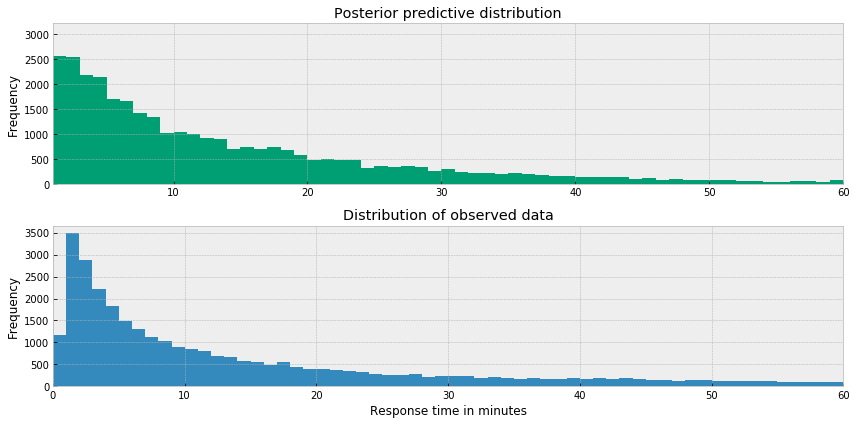

In [45]:
combined_y_pred = np.concatenate([v.get_values('y_pred') for k, v in indiv_traces.items()])

x_lim = 60
y_pred = trace_h.get_values('y_pred')

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(combined_y_pred, range=[0, x_lim], bins=x_lim, color=colors[1])   
_ = plt.xlim(0, x_lim)
# _ = plt.ylim(0, 2000)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(df['response_time'].values, range=[0, x_lim], bins=x_lim)
_ = plt.xlim(0, x_lim)
_ = plt.xlabel('Response time in minutes')
# _ = plt.ylim(0, 2000)
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout();

## Bayesian Hierarchical Regression

In [10]:
df = df[['response_time', 'author_id_y', 'created_at_y_is_weekend', 'word_count']]
formula = 'response_time ~ ' + ' + '.join(['%s' % variable for variable in df.columns[1:]])
formula

'response_time ~ author_id_y + created_at_y_is_weekend + word_count'

In [13]:
import theano.tensor as tt

le = preprocessing.LabelEncoder()
airlines_idx = le.fit_transform(df['author_id_y'])
airlines = le.classes_
n_airlines = len(airlines)

with pm.Model() as model_hr:

    intercept = pm.Normal('intercept', mu=0, sd=100, shape=n_airlines)
    slope_created_at_y_is_weekend = pm.Normal('slope_created_at_y_is_weekend', mu=0, sd=100)
    slope_word_count = pm.Normal('slope_word_count', mu=0, sd=100)
    
    μ = tt.exp(intercept[airlines_idx] 
                + slope_created_at_y_is_weekend*df.created_at_y_is_weekend
                + slope_word_count*df.word_count)
    
    y_est = pm.Poisson('y_est', mu=μ, observed=df['response_time'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace_hr = pm.sample(5000, step, start=start, progressbar=True)

/opt/tljh/user/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -2.4349e+05, ||grad|| = 45.79: 100%|██████████| 150/150 [00:00<00:00, 340.51it/s]     
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [slope_word_count]
>Metropolis: [slope_created_at_y_is_weekend]
>Metropolis: [intercept]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:51<00:00, 215.63draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


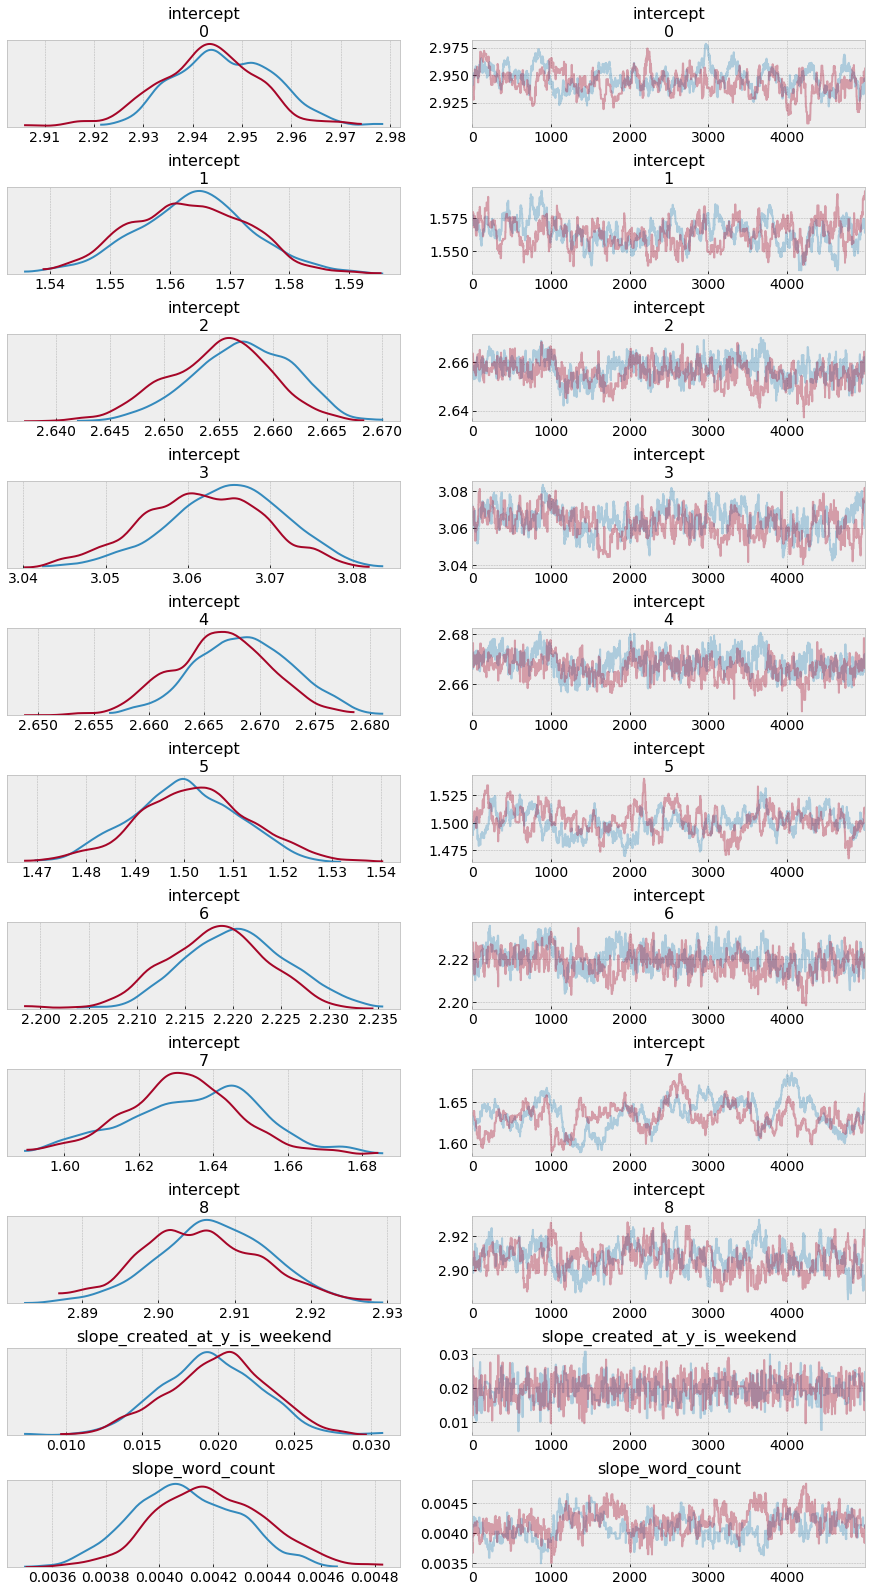

In [14]:
az.plot_trace(trace_hr);

/opt/tljh/user/lib/python3.6/site-packages/arviz/plots/forestplot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/opt/tljh/user/lib/python3.6/site-packages/arviz/plots/forestplot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


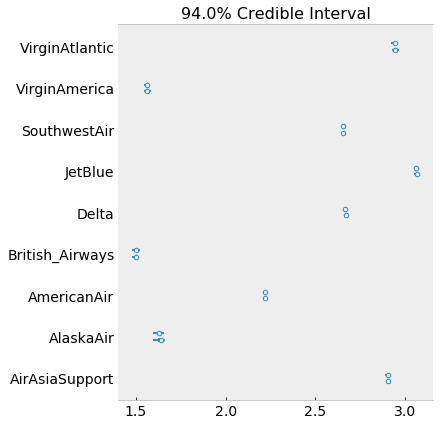

In [20]:
_, ax = pm.forestplot(trace_hr, var_names=['intercept'])
ax[0].set_yticklabels(airlines.tolist());

The model estimates the above β0 (intercept) parameters for every airline. The dot is the most likely value of the parameter for each airline. It look like our model has very little uncertainty for each airline. 

In [17]:
ppc = pm.sample_posterior_predictive(trace_hr, samples=2000, model=model_hr)
az.r2_score(df.response_time.values, ppc['y_est'])

100%|██████████| 2000/2000 [00:10<00:00, 192.17it/s]


r2        0.624787
r2_std    0.091393
dtype: float64